In [1]:
from utils.EDA.analysis import *
from utils.EDA.visualize import *

In [2]:
import statsmodels.api as sm

In [3]:
def LinearReg(data, target, *features):
    y = np.array(data[target])[np.newaxis].T

    X = np.ones([len(data), 1])
    for feature in features:
        X = np.hstack((X, np.array(data[feature])[np.newaxis].T))

    w, resid, rank, s = np.linalg.lstsq(X, y)

    print("w{} : {}".format("Const", w[0]), end = " ")
    
    for i in range(len(w)-1):
        print("w{} : {}".format(features[i], w[i+1]), end = " ")
        
    RMSE = np.sqrt(resid / len(data))
    print("\n RMSE : {}".format(RMSE))
    print("rank : {}".format(rank))
    
    print("cross validation : {}".format(crossValidation(10, data, target, *features)))
    
    # draw chart
    # 예측치와 실제치과의 관계표시(scatter plot)
    predict = np.dot(X, w)
    
    plt.scatter(y, predict)
    plt.xlabel("target value")
    plt.ylabel("predict value")
    plt.xlim(data[target].min(), data[target].max())
    plt.show()

In [4]:
def crossValidation(num, data, target, *features):
    rmses = []
    
    # 데이터프래임에서 target과 features 추출 
    data = data[[*features, target]]
    
    # 데이터프래임 num 갯수로 분할
    remain = data.shape[0] % num
    data_set = np.split(data.values[:data.shape[0]-remain], num)
    data_set[num-1] = np.vstack([data_set[num-1], data.values[data.shape[0]-remain:]])
    
    # 각 fold로 계산하여 rmse를 계산
    for i in range(num):
        
        # test_set과 train_set 제작
        test_set = data_set[i] # test set 

        if (i==0): # train set
            train_set = data_set[1:]
        elif (i==9):
            train_set = data_set[:num-1]
        else:
            train_set = data_set[:i]
            train_set += data_set[i+1:]
        train_set = np.concatenate(train_set)
        
        # train_set으로 linear regression 모델 훈련
        y = train_set[:, -1][np.newaxis].T
        X = np.ones([train_set.shape[0], 1])
        X = np.hstack((X, train_set[:, :train_set.shape[1]-1]))
        
        w, resid, rank, s = np.linalg.lstsq(X, y)
        
        # test_set으로 predict 계산 및 target 생성
        test_X = np.hstack((np.ones([test_set.shape[0], 1]), test_set[:, :test_set.shape[1]-1]))
        predict_test = np.dot(test_X, w).T[0]
        target_test = test_set[:,-1]
        
        # rmse 계산
        rss = np.square(predict_test - target_test).sum()
        rmses.append(np.sqrt(rss / test_X.shape[0]))    
    
    # rmse_avr 계산
    rmse_avr = sum(rmses) / num
    
    # print rmse
#     for idx, rmse in enumerate(rmses):
#         print("test{} : {:1.2f}".format(idx, rmse), end = " ")
    
#     print("\n average of rmse : {:1.2f}".format(rmse_avr))
    return rmse_avr
        

In [5]:
def LinearRegSM(data, target, *features):
    y = np.array(data[target])[np.newaxis].T
    
    #data[*features]
    dfX = sm.add_constant(data[[*features]])
    dfy = data[target]
    
    model = sm.OLS(dfy, dfX)
    result = model.fit()
    print(result.summary())
    return result

In [6]:
plt.style.use("ggplot")

In [19]:
df_train = pd.read_csv("../data/train_no_missing.csv")
df_test = pd.read_csv("../data/test.csv")

# LinearRegression

In [20]:
get_top_abs_cor(df_train, 10,  "SalePrice")

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
FirstFlrSF      0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

In [21]:
top_cor = get_top_abs_cor(df_train, 10,  "SalePrice").index.values

523, 1298

### 실험

In [12]:
get_top_abs_cor(df_train[top_cor], 10)

GarageCars   GarageArea      0.882475
GrLivArea    TotRmsAbvGrd    0.825489
TotalBsmtSF  1stFlrSF        0.819530
GrLivArea    FullBath        0.630012
OverallQual  GarageCars      0.600671
             GrLivArea       0.593007
YearBuilt    YearRemodAdd    0.592855
OverallQual  YearBuilt       0.572323
GrLivArea    1stFlrSF        0.566024
OverallQual  GarageArea      0.562022
dtype: float64

연관이 있는 값인 (GarageCars, GarageArea), (GrLivArea, TotRmsAbvGrd), (TotalBsmtSF, 1stFlrSF) 에서 "GarageArea", "TotRmsAbvGrd", "1stFlrSF" 제거
37686 -> 37591 로 감소

# Logarithm

SalePrice

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 10.46024211,  10.47194981,  10.54270639, ...,  13.34550693,
          13.5211395 ,  13.53447303])),
 (0.39826223081618872, 12.024050901109383, 0.99537614756366133))

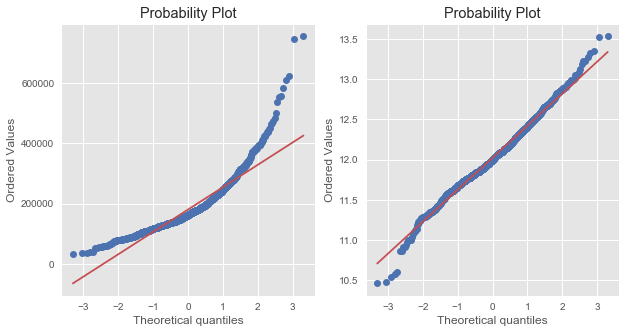

In [23]:
log_SalePrice = np.log(df_train["SalePrice"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["SalePrice"], plot = axes[0])
sp.stats.probplot(log_SalePrice, plot = axes[1])

LotFrontage(선택)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 3.04452244,  3.04452244,  3.04452244, ...,  5.82699111,
          5.98832974,  6.00581901])),
 (0.37349497217086036, 4.2683518701134853, 0.97777186333051269))

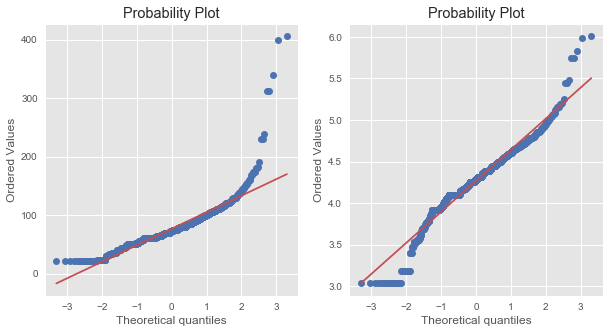

In [24]:
log_Frontage = np.log(df_train["LotFrontage"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["LotFrontage"], plot = axes[0])
sp.stats.probplot(log_Frontage, plot = axes[1])

LotArea(선택)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([  7.17011954,   7.29776828,   7.30720231, ...,  11.97665948,
          12.01163802,  12.27953219])),
 (0.49279975916869634, 9.1108382395055472, 0.95079366848515501))

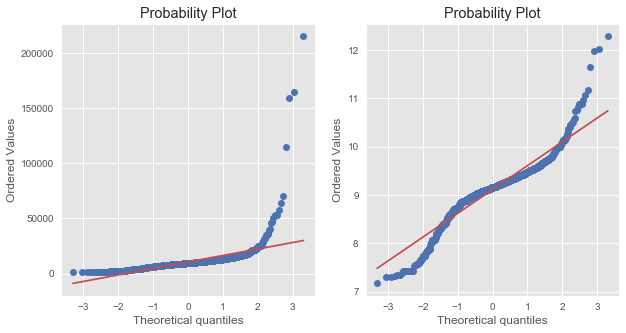

In [25]:
log_LotArea = np.log(df_train["LotArea"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["LotArea"], plot = axes[0])
sp.stats.probplot(log_LotArea, plot = axes[1])

1stFlrSF(선택)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 5.81114099,  5.91889385,  6.08221891, ...,  8.05134093,
          8.07961803,  8.45361421])),
 (0.31748920647999668, 7.0075014449454125, 0.99759244073844833))

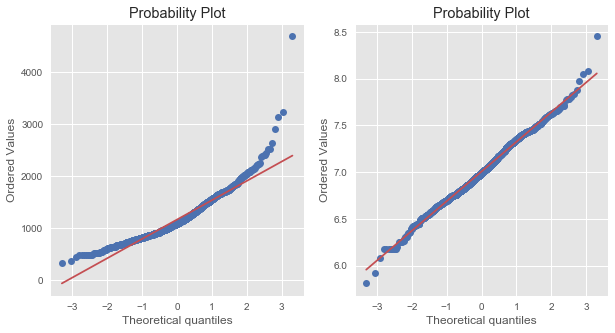

In [27]:
log_1stFlrSF = np.log(df_train["FirstFlrSF"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["FirstFlrSF"], plot = axes[0])
sp.stats.probplot(log_1stFlrSF, plot = axes[1])

GrLivArea(선택)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 5.81114099,  6.08221891,  6.1737861 , ...,  8.40648507,
          8.45019832,  8.63799389])),
 (0.33334425318908878, 7.2677743833110044, 0.9977323160680609))

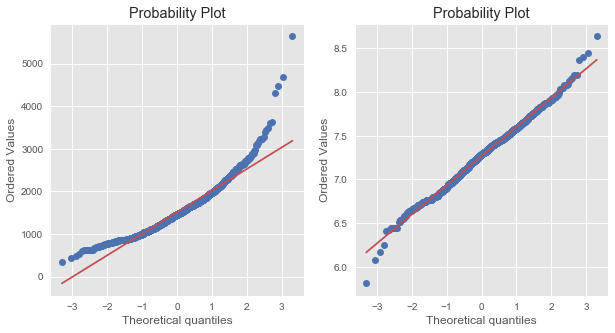

In [28]:
log_GrLivArea = np.log(df_train["GrLivArea"])
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_train["GrLivArea"], plot = axes[0])
sp.stats.probplot(log_GrLivArea, plot = axes[1])

In [21]:
list(top_cor)

['OverallQual',
 'GrLivArea',
 'GarageArea',
 '1stFlrSF',
 'FullBath',
 'YearBuilt',
 'YearRemodAdd']

wConst : [-0.57016004] wOverallQual : [ 0.09770421] wlog_GrLivArea : [ 0.41726789] wGarageArea : [ 0.00024504] w1stFlrSF : [ 0.00012699] wFullBath : [-0.03467714] wYearBuilt : [ 0.00222782] wYearRemodAdd : [ 0.00219903] 
 RMSE : [ 0.16740026]
rank : 8
cross validation : 0.16763803040371542


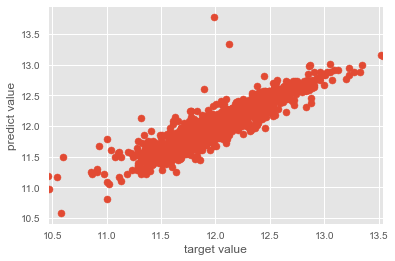

In [31]:
# log 사용(SalePrice, GrLivArea)
result = LinearReg(df_new_train, "log_SalePrice", 
                   'OverallQual',
                   'log_GrLivArea',
                   'GarageArea',
                   '1stFlrSF',
                   'FullBath',
                   'YearBuilt',
                   'YearRemodAdd')
# 0.17 -> 0.16

# make new features about SF

In [32]:
df_train.filter(regex = "SF").tail()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,WoodDeckSF,OpenPorchSF
1455,0,0,953,953,953,694,0,0,40
1456,790,163,589,1542,2073,0,0,349,0
1457,275,0,877,1152,1188,1152,0,0,60
1458,49,1029,0,1078,1078,0,0,366,0
1459,830,290,136,1256,1256,0,0,736,68


In [33]:
# make Area

In [34]:
df_new_train["TotalArea"] = df_train[["1stFlrSF", "2ndFlrSF", "TotalBsmtSF", "LowQualFinSF"]].sum(axis = 1)

In [35]:
sum(df_new_train["TotalArea"] == 0)

0

In [36]:
# make porch Area

In [37]:
df_new_train.filter(regex = "Porch").columns

Index(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], dtype='object')

In [38]:
df_new_train["PorchArea"] = df_new_train[["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]].sum(axis = 1)

In [39]:
sum(df_new_train["PorchArea"] == 0)

458

In [31]:
# salesPrice와의 상관관계

In [40]:
df_new_train[["SalePrice", "TotalArea", "PorchArea"]].corr()

,SalePrice,TotalArea,PorchArea
SalePrice,1.000000,0.778959,0.195739
TotalArea,0.778959,1.000000,0.256903
PorchArea,0.195739,0.256903,1.000000


In [42]:
# TotalArea는 1SF보다 더 상관관계가 많다. 그래서 TotalArea 추가
cor = df_train[df_new_train].corr()
cor["GrLivArea"].sort_values(ascending = False)[:10]

ValueError: Must pass DataFrame with boolean values only

In [35]:
# totalArea 분석

1.7780291853852757

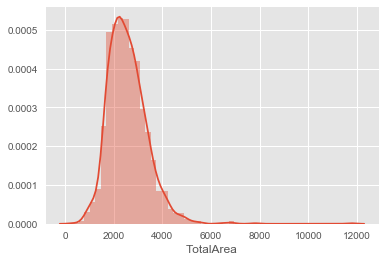

In [43]:
sns.distplot(df_new_train["TotalArea"])
df_new_train["TotalArea"].skew()

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 5.81114099,  6.57925121,  6.59030105, ...,  8.83521046,
          8.96367228,  9.37177872])),
 (0.31076720393211182, 7.8047957883507637, 0.99046393947878586))

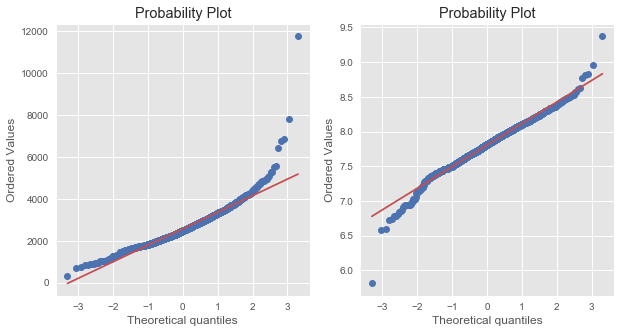

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sp.stats.probplot(df_new_train["TotalArea"], plot = axes[0])
sp.stats.probplot(np.log(df_new_train["TotalArea"]), plot = axes[1])
# 사용하지 않음

In [45]:
cor_top = df_new_train[["log_SalePrice",
              'OverallQual',
              'log_GrLivArea',
              'GarageArea',
              '1stFlrSF',
              'FullBath',
              'YearBuilt',
              'YearRemodAdd', "TotalArea"]].corr()

In [46]:
cor_top["TotalArea"].sort_values(ascending = False)

TotalArea        1.000000
log_GrLivArea    0.848739
1stFlrSF         0.797678
log_SalePrice    0.773277
OverallQual      0.664830
FullBath         0.574403
GarageArea       0.558466
YearRemodAdd     0.338404
YearBuilt        0.335488
Name: TotalArea, dtype: float64

wConst : [ 0.23921528] wOverallQual : [ 0.09177369] wlog_GrLivArea : [ 0.30192579] wGarageArea : [ 0.00025125] wFullBath : [-0.0322001] wYearBuilt : [ 0.00218646] wYearRemodAdd : [ 0.00221543] wTotalArea : [  9.90613250e-05] 
 RMSE : [ 0.16725711]
rank : 8
cross validation : 0.16876064312877986


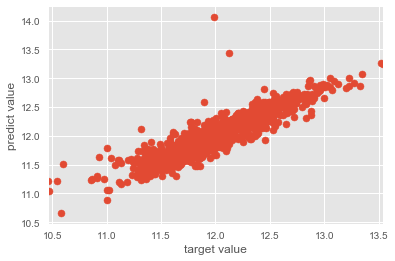

In [47]:
#log 사용(SalePrice, GrLivArea)
result = LinearReg(df_new_train, "log_SalePrice",
              'OverallQual',
              'log_GrLivArea',
              'GarageArea',
              'FullBath',
              'YearBuilt',
              'YearRemodAdd', 
              "TotalArea" )
# 0.167 -> 0.168

In [56]:
#log 사용(SalePrice, GrLivArea)
result = LinearRegSM(df_new_train, "log_SalePrice",
              'OverallQual',
              'log_GrLivArea',
              'GarageArea',
              'FullBath',
              'YearBuilt',
              'YearRemodAdd', 
              "TotalArea",
                    *neibor)
# 0.167 -> 0.168

                            OLS Regression Results                            
Dep. Variable:          log_SalePrice   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     279.9
Date:                Fri, 02 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:03:46   Log-Likelihood:                 697.06
No. Observations:                1460   AIC:                            -1330.
Df Residuals:                    1428   BIC:                            -1161.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.7196 

In [50]:
neibor = df_new_train.filter(regex="Neighbor").columns

In [55]:
#log 사용(SalePrice, GrLivArea)
result = LinearRegSM(df_new_train, 
                    "log_SalePrice", *neibor)
# 0.167 -> 0.168

                            OLS Regression Results                            
Dep. Variable:          log_SalePrice   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     79.52
Date:                Fri, 02 Mar 2018   Prob (F-statistic):          4.04e-243
Time:                        21:02:59   Log-Likelihood:                -113.89
No. Observations:                1460   AIC:                             277.8
Df Residuals:                    1435   BIC:                             409.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.5674 